## DESEQ2 analysis of DMSO dataset

2 Factor design: 

* Treatment (DMSO v Control) 
* Cell Cycle (earlyG1, lateG1, SG2M) 

* 160,698 naive overlap peaks 
* 2 biological replicates per Sample (Treatment/CellCycle combination) 

In [47]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")

## Load data and design

In [48]:
#load ATAC-seq raw read counts
data=read.table('atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL



In [4]:
#load the metadata
batches=read.table("../atacseq_batches_truerep.txt",header=TRUE,sep='\t',row.names=1)
batches$CellCycle=factor(batches$CellCycle)
batches$Treatment=factor(batches$Treatment)
batches$Sample=factor(batches$Sample)


In [5]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~CellCycle + CellCycle:Treatment)


## Visualizations 

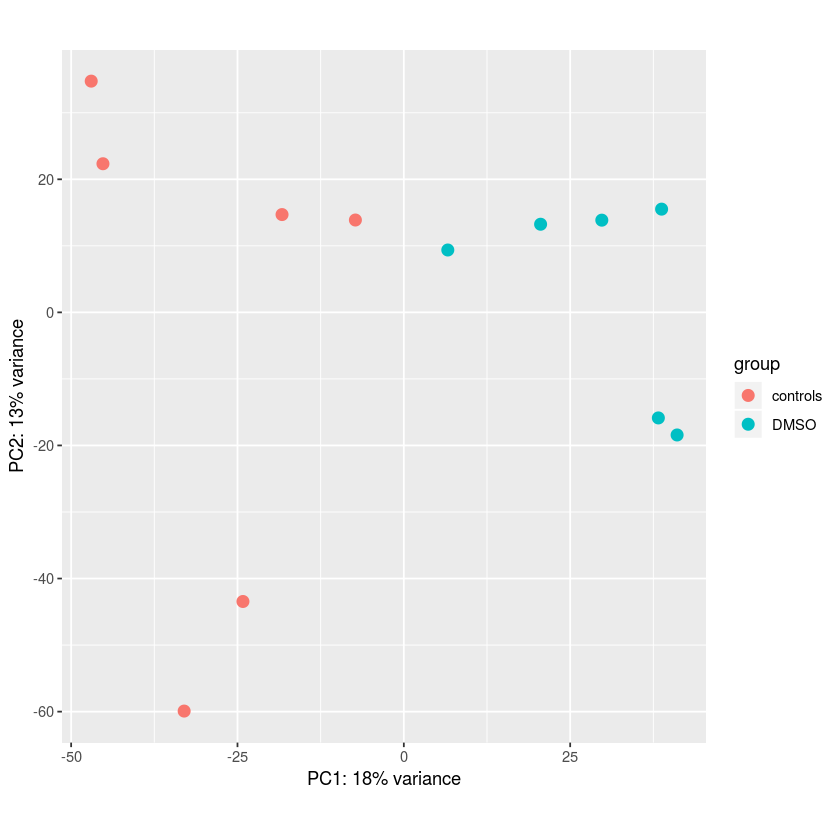

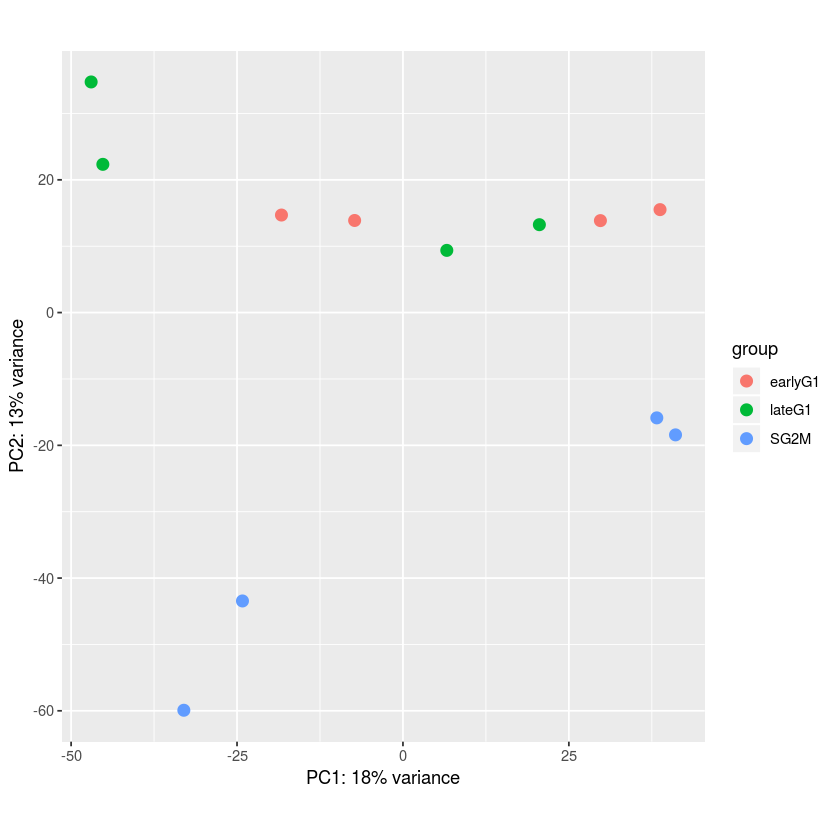

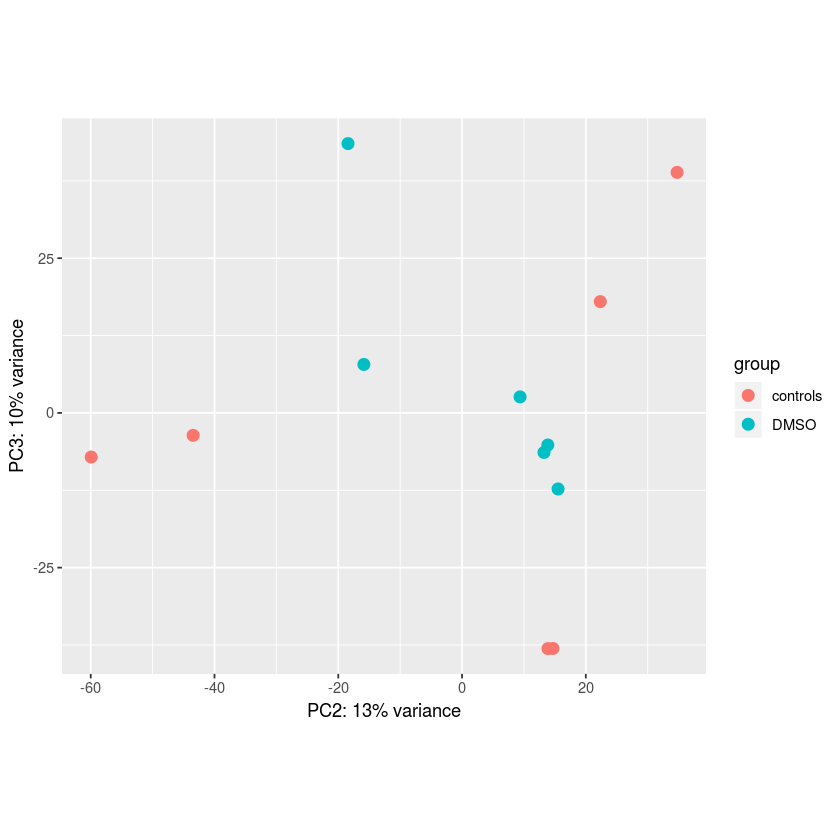

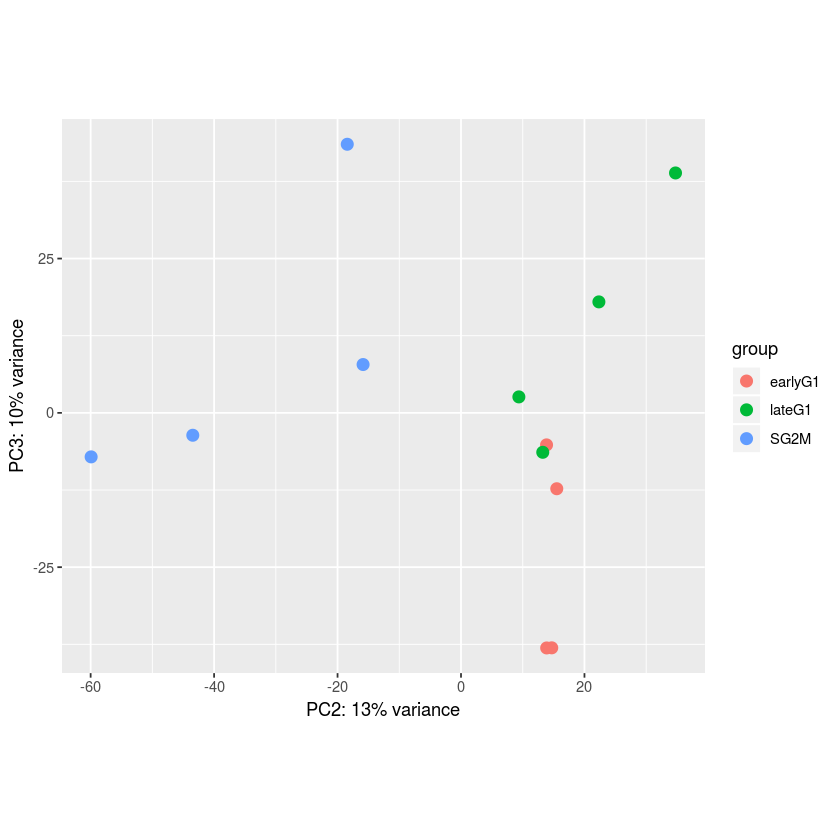

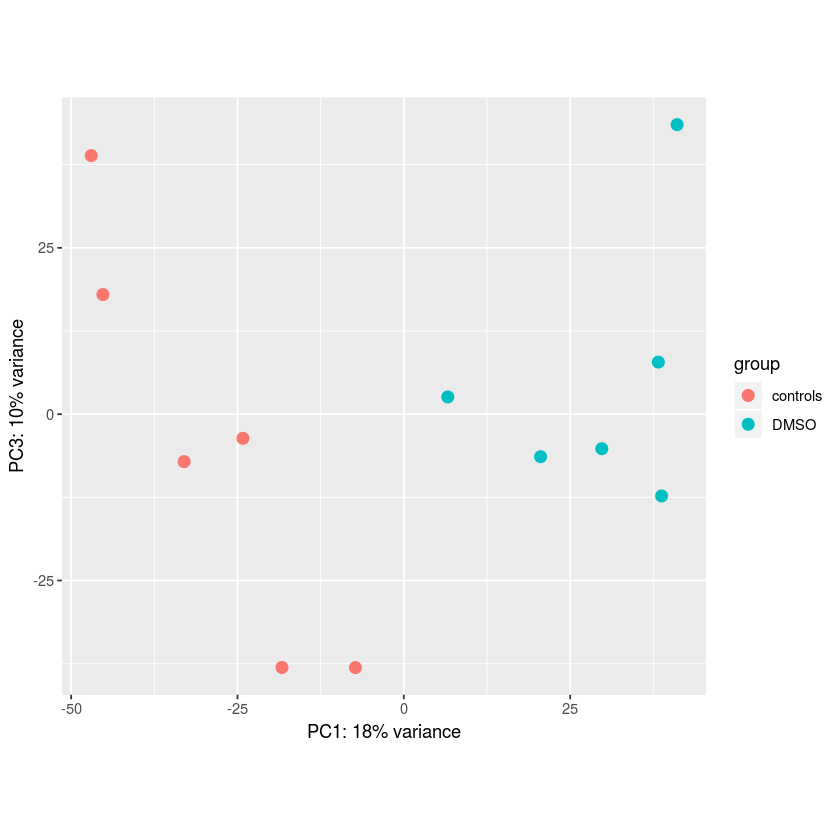

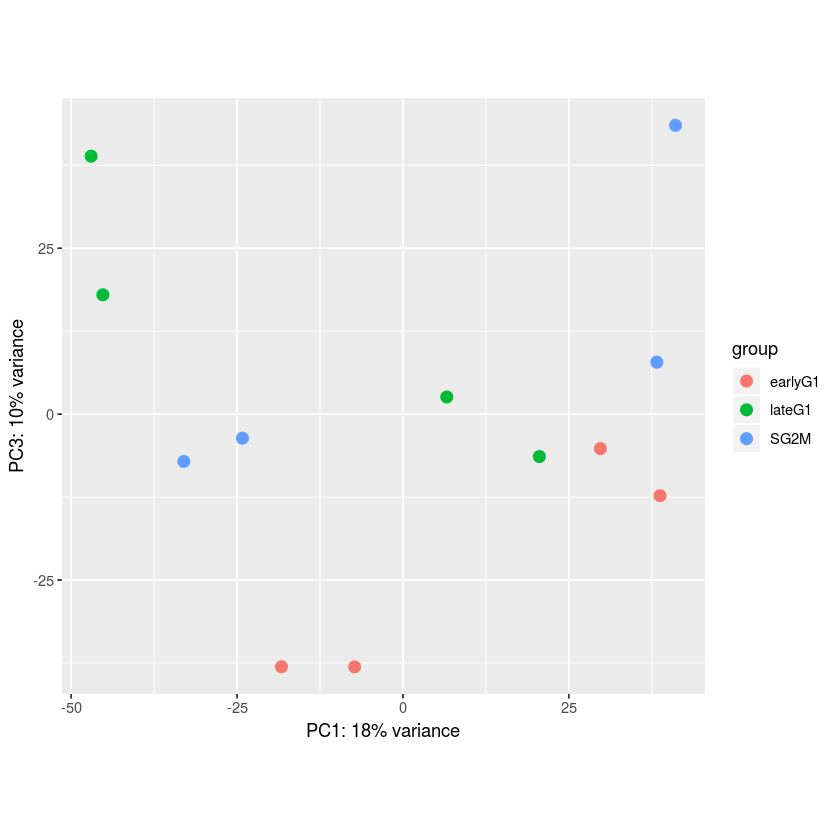

In [6]:
#PCA on vst-transformed data
vst_data=vst(dds)
source('plotPCA_custom.R')
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=160698,returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=160698,returnData=FALSE,pcx=2,pcy=3)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=2,pcy=3)
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=160698,returnData=FALSE,pcx=1,pcy=3)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=1,pcy=3)


In [7]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("HK.promoters.txt",header=TRUE,sep='\t')
hk_promoters=paste(hk_promoters$Chrom,hk_promoters$Start,hk_promoters$End,sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))


In [8]:
dds <- estimateSizeFactors(dds, controlGenes=hk_promoter_indices)


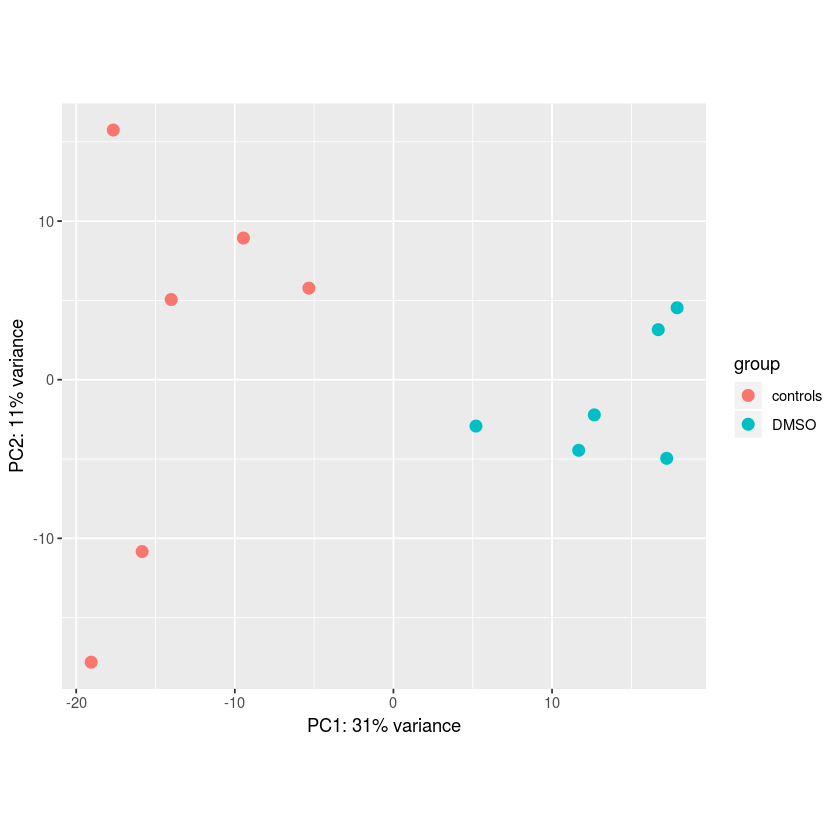

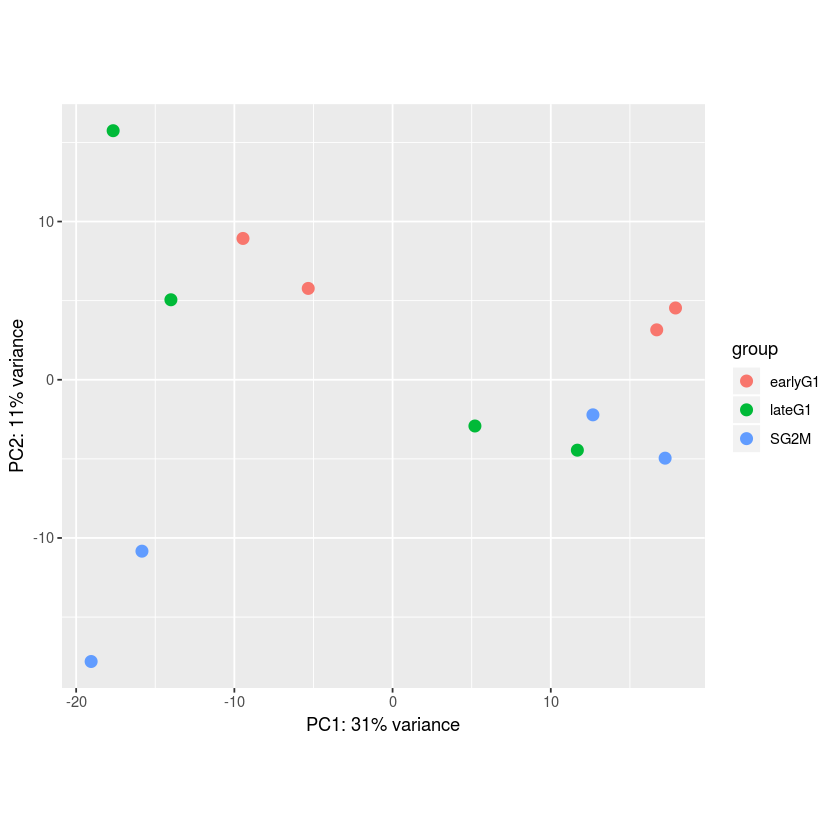

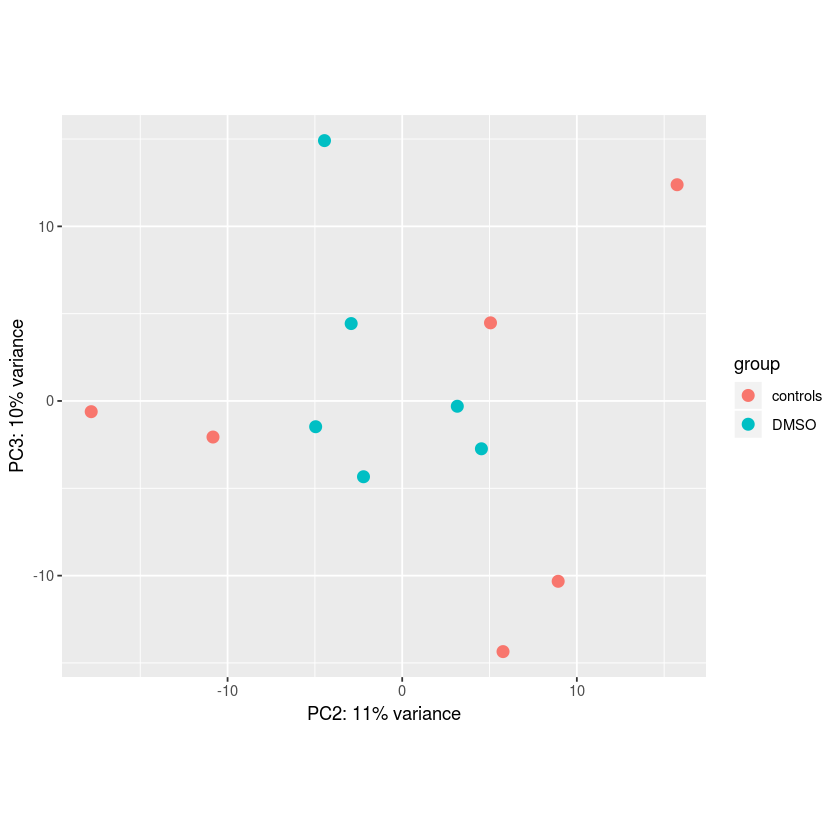

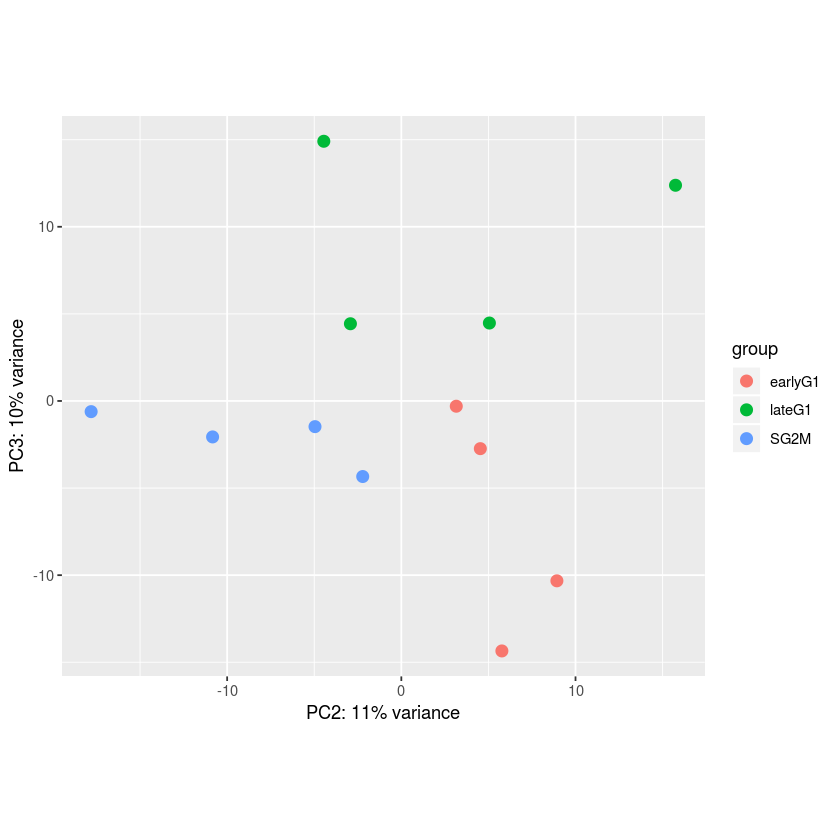

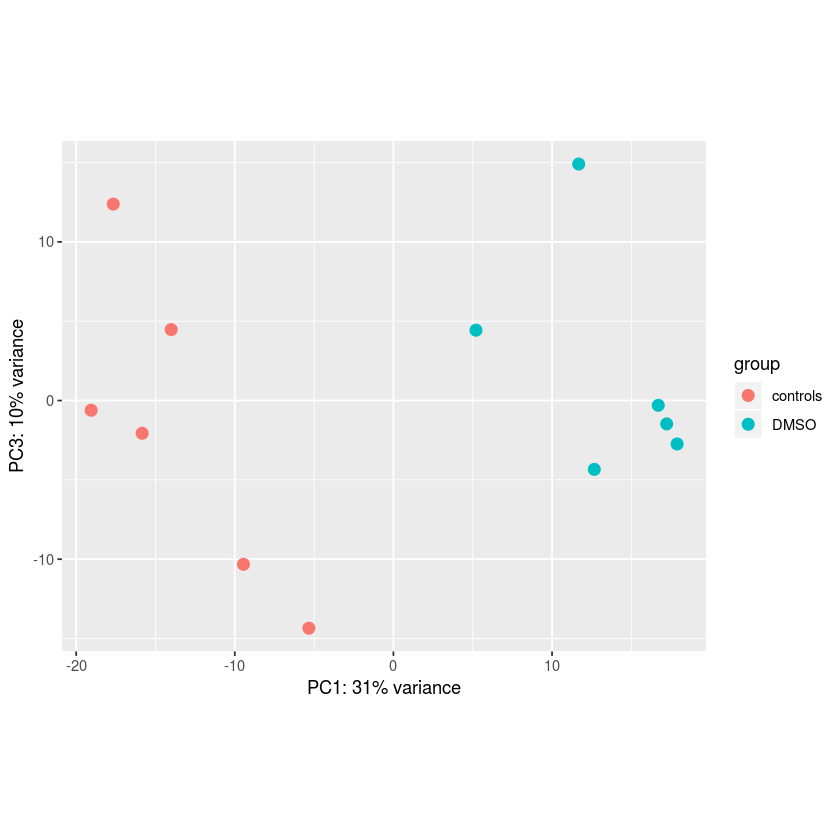

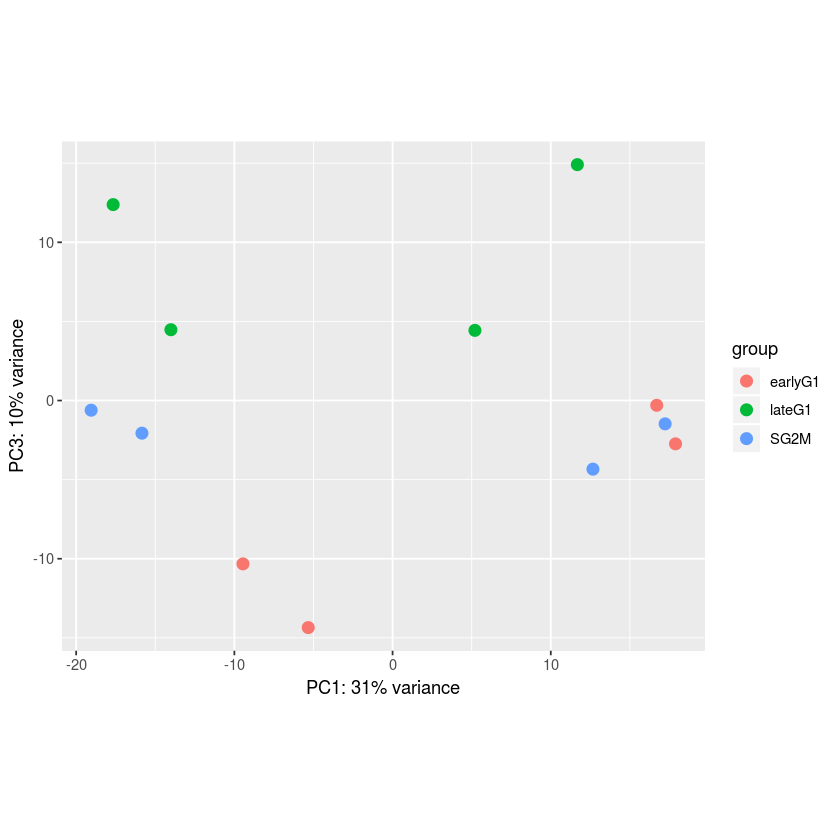

In [9]:
#PCA on vst-transformed data w/ custom sizeFactors
# shifted log of normalized counts
se <- SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
# the call to DESeqTransform() is needed to
# trigger our plotPCA method.
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=2,pcy=3)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=3)
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=3)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=1,pcy=3)

In [10]:
## Perform transformations 
vsd=vst(dds,blind=FALSE)
rld=rlog(dds,blind=FALSE)
ntd <- normTransform(dds)



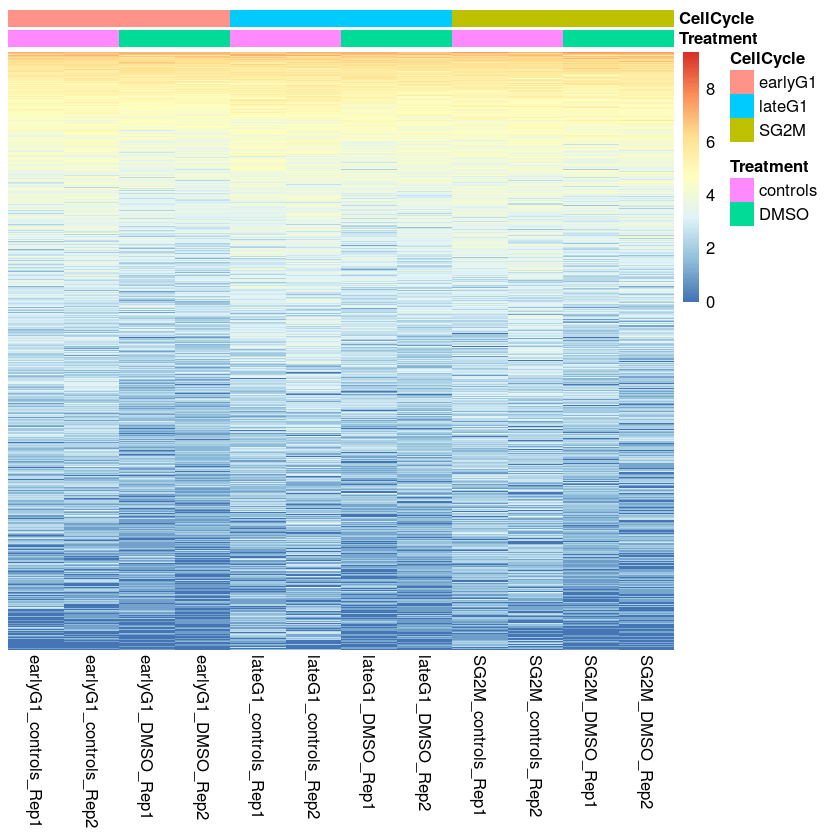

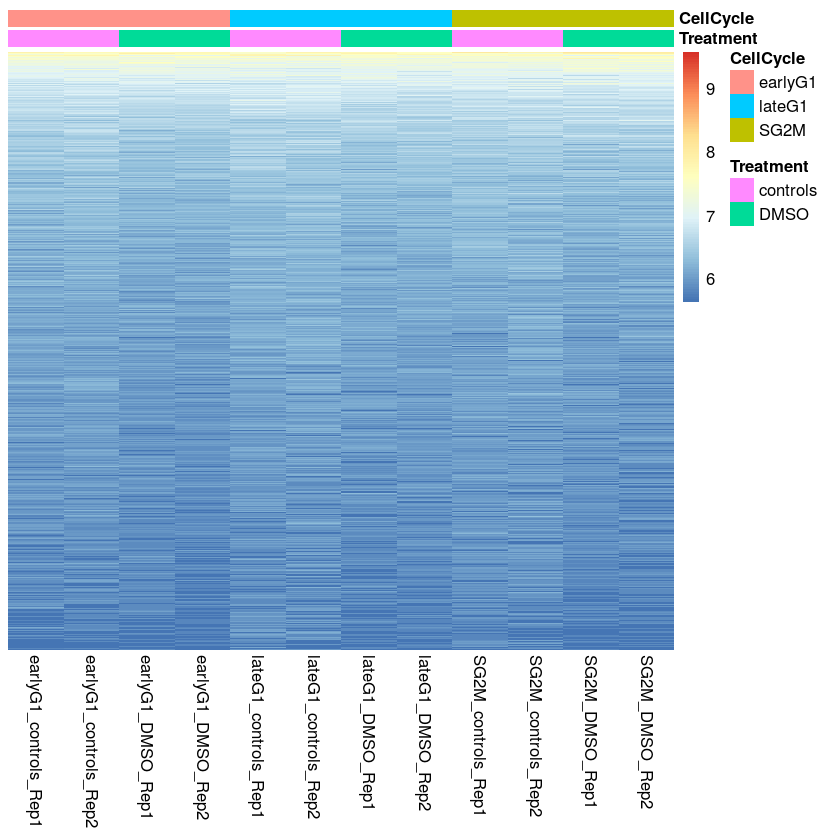

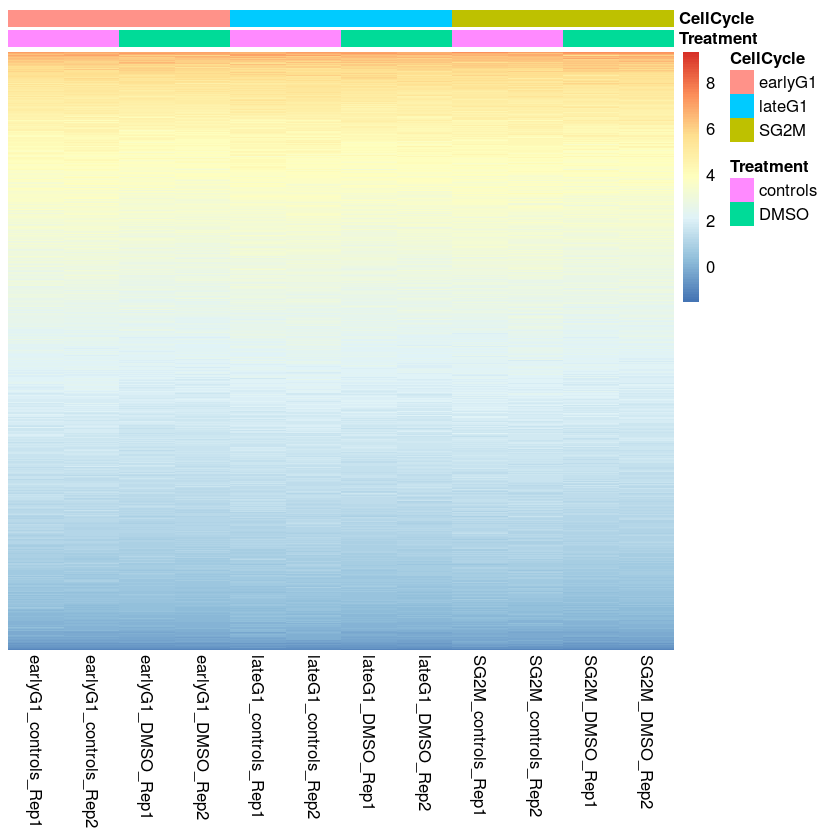

In [11]:
## Heatmap on Transformed Data 

select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)


df <- as.data.frame(colData(dds)[,c("Treatment","CellCycle")])

#log2(n + 1)
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#VST Transform 
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#Rlog Transform 
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

## Differential Accessibility Operation

In [12]:
#Run the differential analysis
dds <- DESeq(dds,parallel = FALSE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Standard BH Correction (no optimal thresholding) 

In [13]:
resultsNames(dds)

[1] "Intercept"                      "CellCycle_lateG1_vs_earlyG1"   
[3] "CellCycle_SG2M_vs_earlyG1"      "CellCycleearlyG1.TreatmentDMSO"
[5] "CellCyclelateG1.TreatmentDMSO"  "CellCycleSG2M.TreatmentDMSO"

In [14]:
res=results(dds)
summary(res)


out of 160698 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9, 0.0056%
LFC < 0 (down)     : 10, 0.0062%
outliers [1]       : 0, 0%
low counts [2]     : 112160, 70%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [15]:
namesToOutput=c("CellCycle_lateG1_vs_earlyG1",
"CellCycle_SG2M_vs_earlyG1",
"CellCycleearlyG1.TreatmentDMSO",
"CellCyclelateG1.TreatmentDMSO",
"CellCycleSG2M.TreatmentDMSO")
numcomparisons=length(namesToOutput)

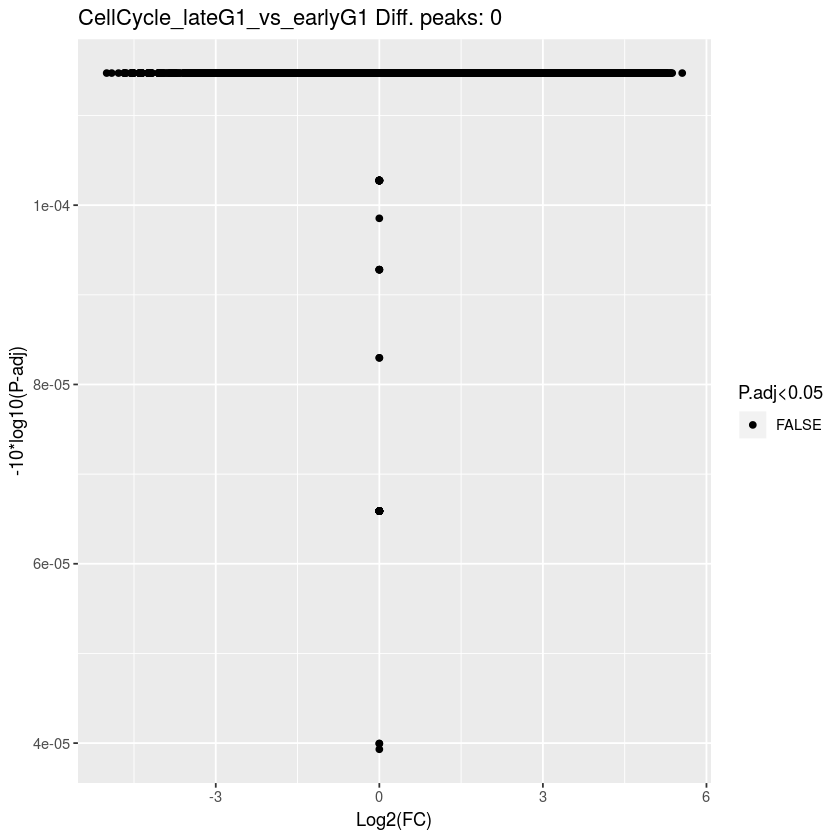

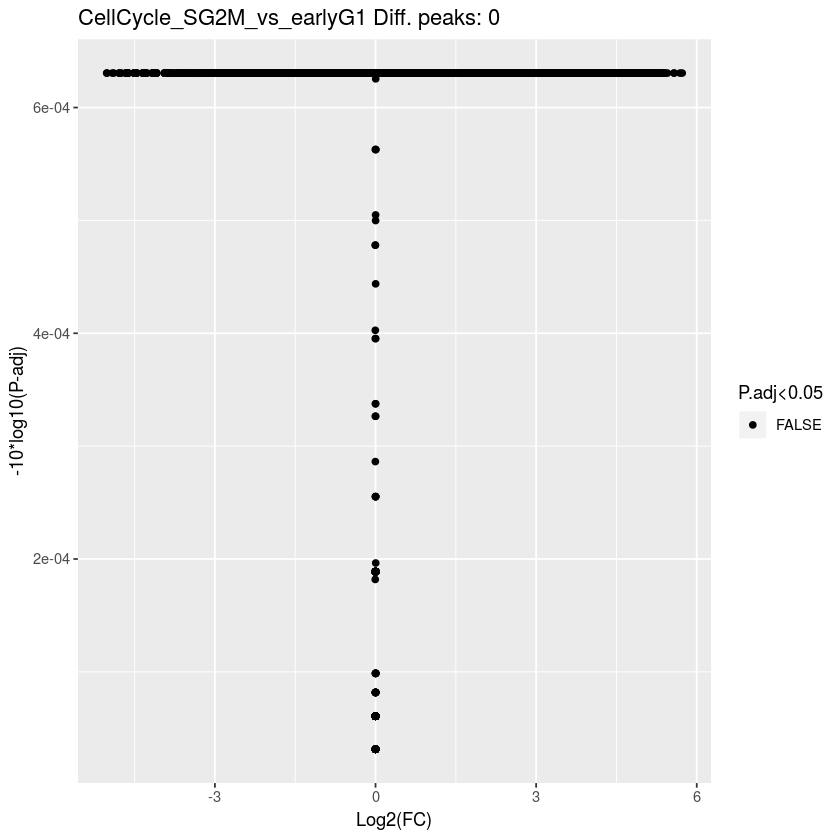

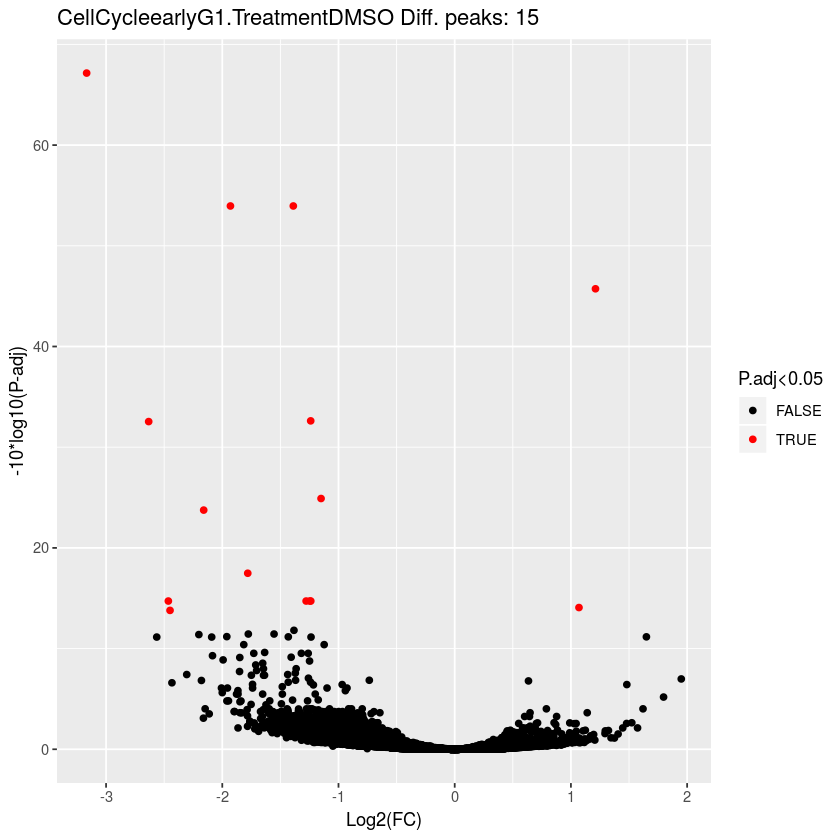

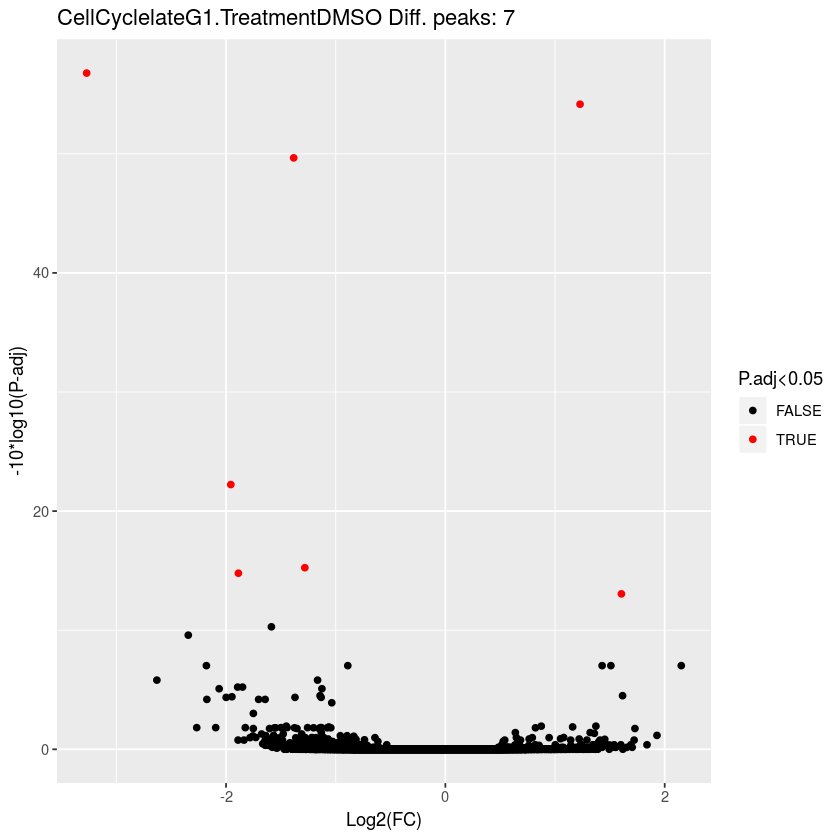

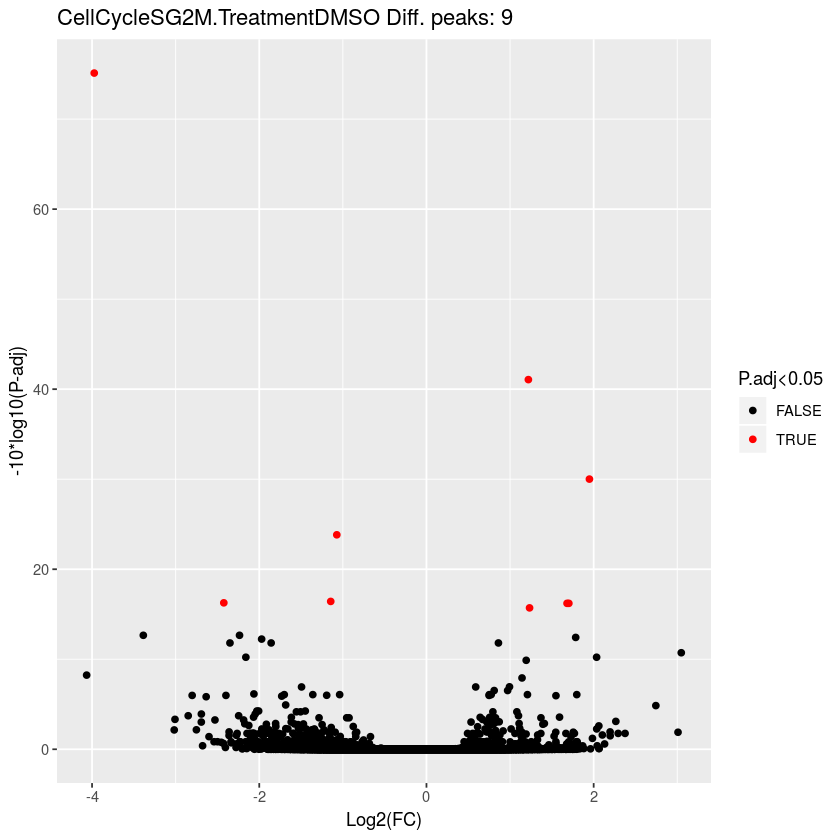

In [16]:
for(i in seq(1,numcomparisons))
{
 res=results(dds,name=namesToOutput[i],parallel=TRUE)
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 numsig=sum(res$padj <= 0.05)
 sigsubset=res[res$padj<=0.05,]

 #output differential analysis results for the contrast
 #outtable=paste(namesToOutput[i],"tsv",sep='.')
 #write.table(sigsubset,file=outtable,quote=FALSE,sep='\t',row.names=TRUE,col.names=TRUE)
 #print(paste(namesToOutput[i],numsig))

 #generate a volcano plot of the differential analysis for the contrast
 #outpng=paste("volcano",namesToOutput[i],"png",sep='.')
 outlabel=paste(namesToOutput[i],"Diff. peaks:",numsig)
 res$color=res$padj<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$log2FoldChange,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
 #dev.off()
}


## Find an Optimal Filtering Threshold with -log10Pval/baseMean

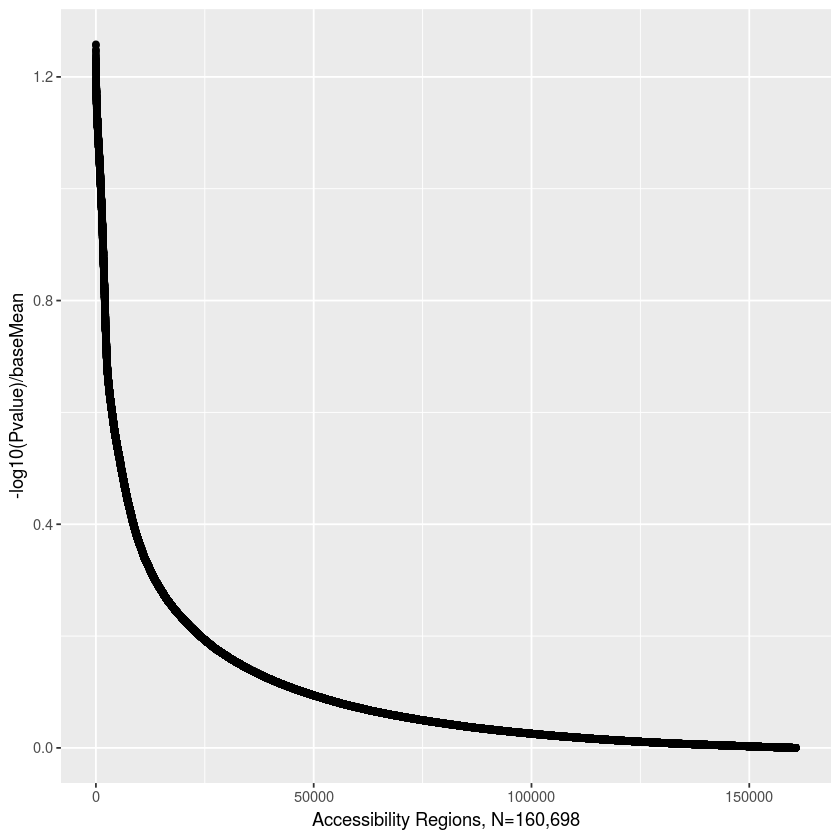

In [17]:
#plot -log10 pvalue over mean of normalized counts over all samples
res=results(dds)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

ggplot(data=res_df,
      aes(x=seq(1,nrow(res_df)),
         y=res_df$filtRatio))+
geom_point()+
xlab("Accessibility Regions, N=160,698")+
ylab("-log10(Pvalue)/baseMean")

We keep the 50,000 peaks with the highest ratio of -log10(Pvalue)/baseMean

In [18]:
mask=rownames(res_df)[50001:nrow(res_df)]

Regenerate volcano plots with the updated p-adjusted values, masking the rows indicated above.

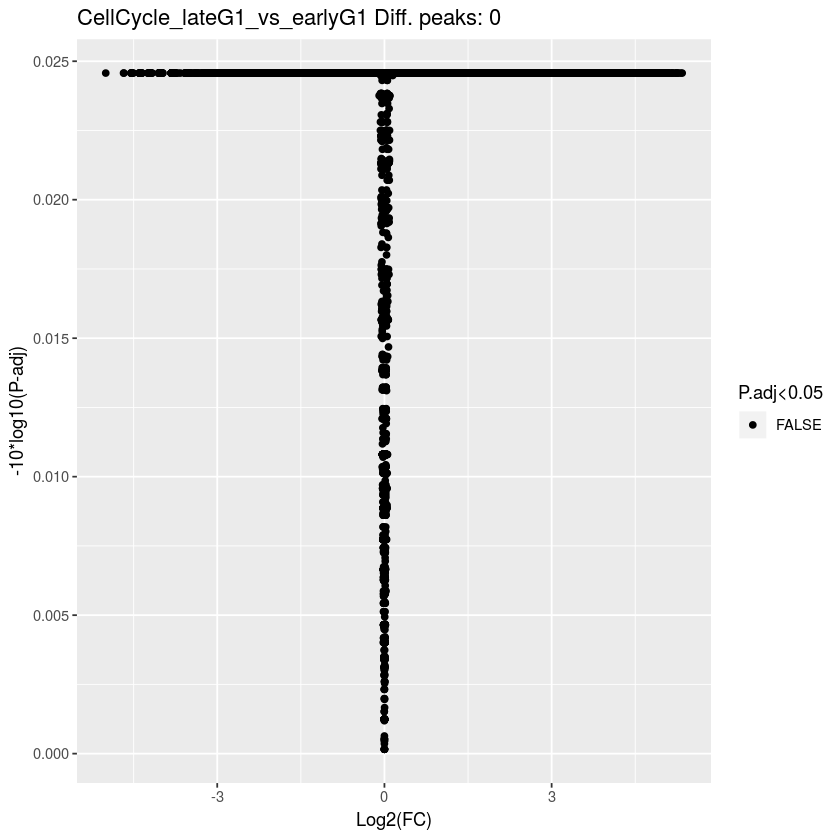

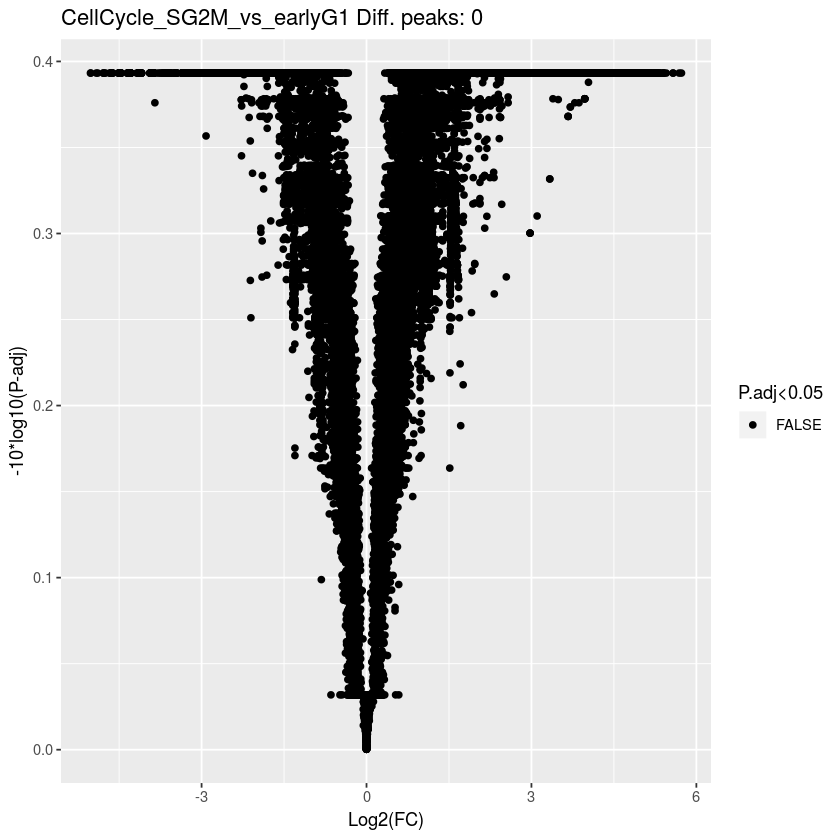

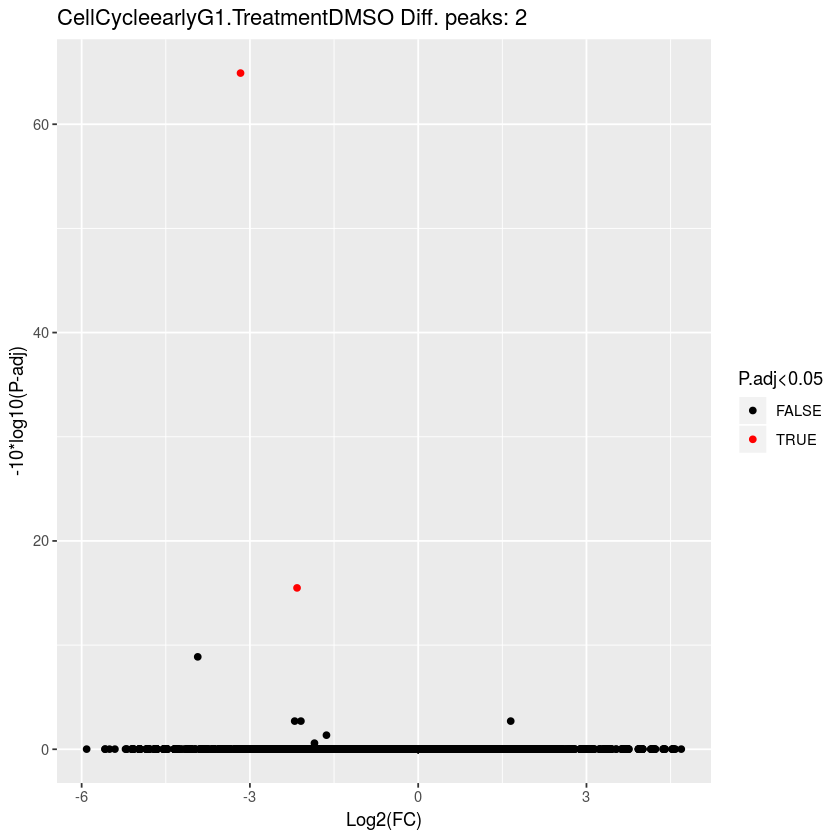

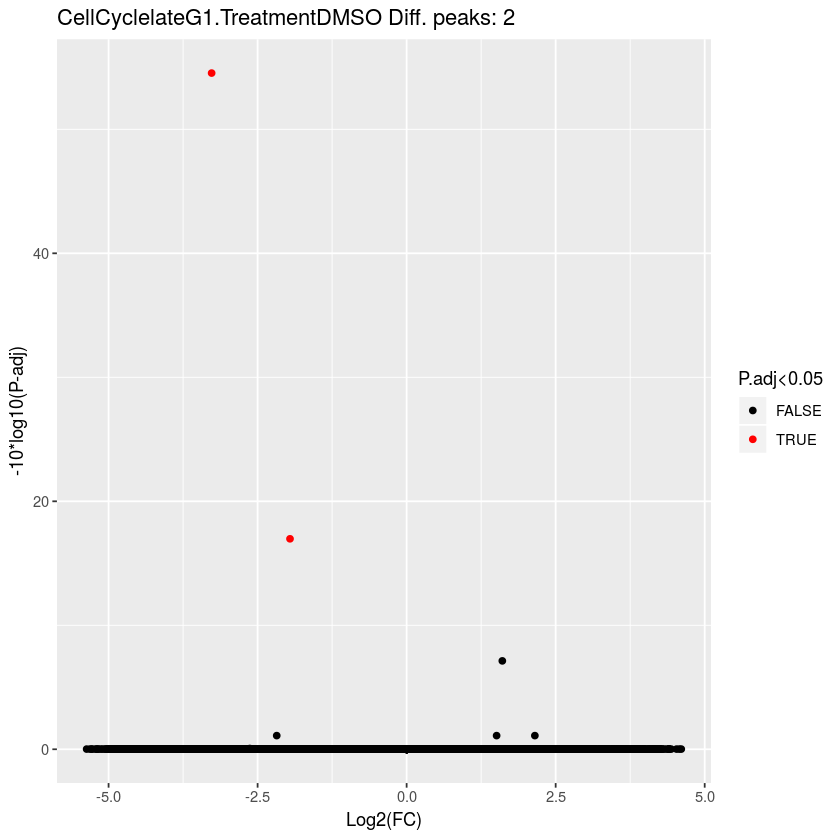

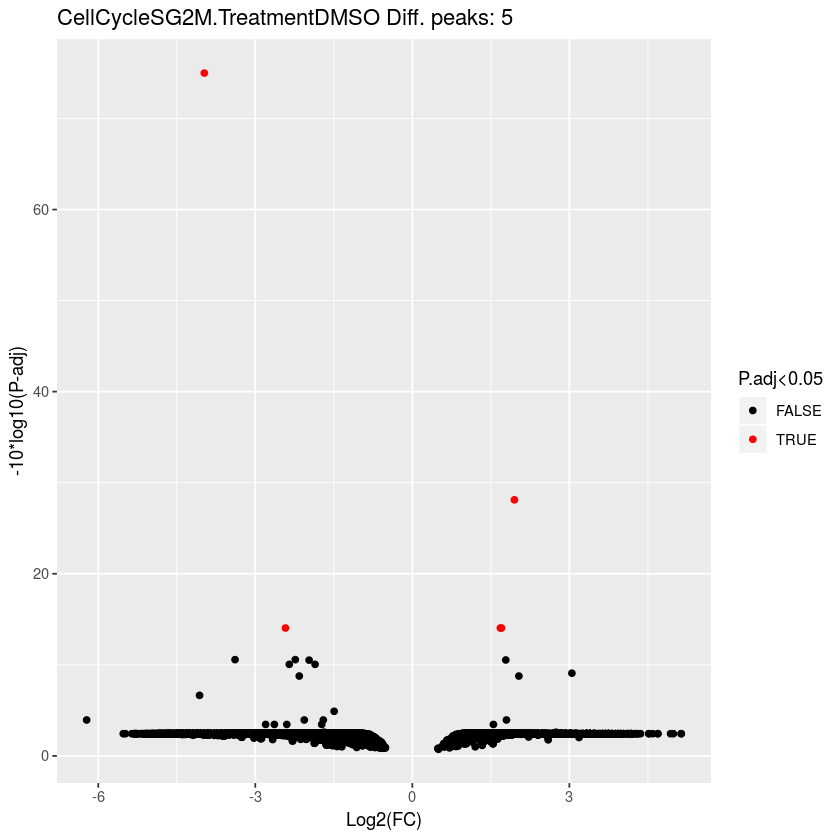

In [38]:
for(i in seq(1,numcomparisons))
{
 res_contrast=results(dds,name=namesToOutput[i],parallel=TRUE)
 res_contrast$pvalue[rownames(res_contrast) %in% mask]=NA
 res_contrast$padj=p.adjust(res_contrast$pvalue,method="BH")
    
 res_contrast$logPadj=-10*log10(res_contrast$padj)
 res_contrast=na.omit(as.data.frame(res_contrast))
 numsig=sum(res_contrast$padj <= 0.05)

 outlabel=paste(namesToOutput[i],"Diff. peaks:",numsig)
 res_contrast$color=res_contrast$padj<=0.05
 print(ggplot(data=res_contrast,
        aes(x=res_contrast$log2FoldChange,
            y=res_contrast$logPadj,
            color=res_contrast$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
}

## Find an optimal filtering threshold with IHW

In [39]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 160698 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 16, 0.01%
LFC < 0 (down)     : 9, 0.0056%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [40]:
sum(resIHW$padj < 0.1, na.rm=TRUE)



[1] 25

In [41]:
metadata(resIHW)$ihwResult



ihwResult object with 160698 hypothesis tests 
Nominal FDR control level: 0.1 
Split into 40 bins, based on an ordinal covariate

## Independent Filtering 

In [42]:
metadata(res)$alpha


[1] 0.1

In [43]:
metadata(res)$filterThreshold


69.79592% 
 9.284283

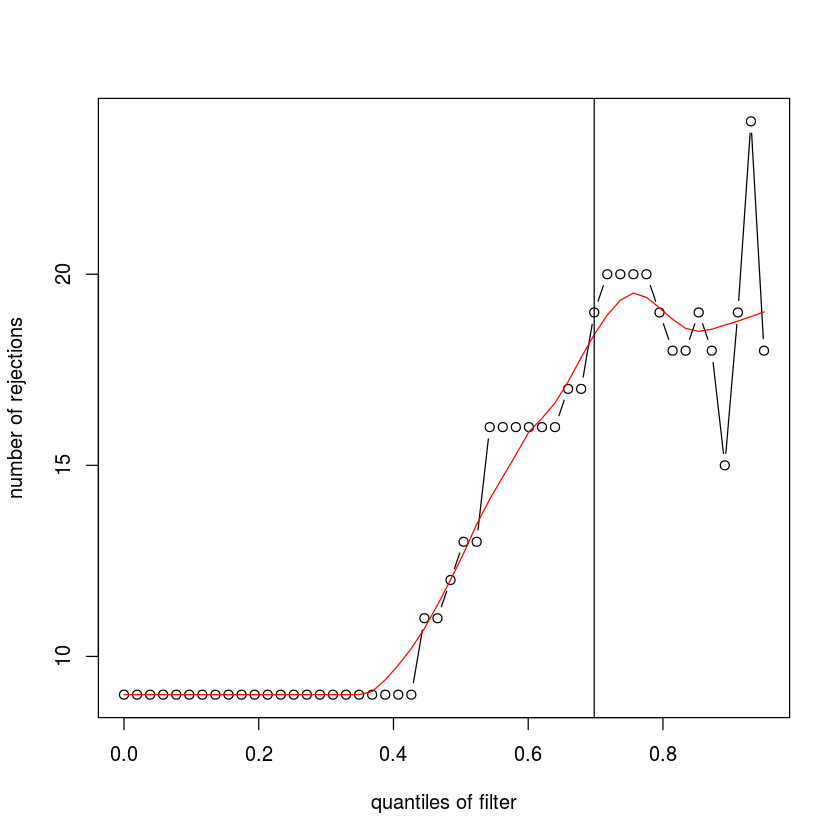

In [44]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [45]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,48519,0,48519
TRUE,10,9,19
Sum,48529,9,48538
